In [4]:
'''
Demos written and developed by: Andrew E. Oriani 2020 EMAIL: oriani@uchicago.edu

'''
import numpy as np
from numpy import pi, cos, sin, sqrt, log
import math
import glob
import time

import ezdxf

#Import plotting libraries for later
import matplotlib
from matplotlib import pyplot as plt

import pandas as pd

import pyEPR
from pyEPR import ansys as HFSS

import scipy
from scipy import constants as const

from pint import UnitRegistry
ureg = UnitRegistry()
Q = ureg.Quantity
cwd=os.getcwd()

# 2D Ansys API demonstration

In this demonstration I wll show how to setup a 2D simulation file for a multi resonator lumped element sample. This design will demonstrate the use of mesh boxes for fatser eigenmode convergence, adding port impedence, and wirebonds. The design is shown below:

<img src="Pictures/QTune image.png" alt="drawing" width="700">

I will demonstrate both an eigenmode and a driven modal setup of the sample and demonstrate how to easily extract model information from those simulation through the API. This module also makes us of the custom pyEPR/Ansys module that is located in the root project file. WIthout the installation of that version of the Ansys module you will be unable to import DXF files into the Ansys environment.

The QTune design is a popular design used in the SchusterLab to test processes and materials and qualify qubit performance. It contains 4 lumped elements LC osscilators attached to a single CPW transmission line in a hanger format. Two qubits are coupled to each resonator allowing for 8 qubits per a sample.

In [47]:
project_name='QTune'
design_name='QTune_EM'
overwrite=True

#use file location path:
#use local path
HFSS_path=cwd

full_path=HFSS_path+"\\Simulation Files\\"+project_name+'.aedt'

chip_path=cwd+'\\QTUNE-QTUNE1.dxf'

HFSS_app=HFSS.HfssApp()
HFSS_desktop=HFSS_app.get_app_desktop()

project=HFSS_desktop.open_project(full_path)

if project==None:
    project=HFSS_desktop.new_project()
    project.save(full_path)
    
project.make_active()
    
if design_name in project.get_design_names():
    if overwrite==True:
        project.delete_design(design_name)
        project.save()
        EM_design=project.new_em_design(design_name)
    else:
        EM_design=project.get_design(design_name)
        
else:
    EM_design=project.new_em_design(design_name)
        
EM_design.make_active()
model=HFSS.HfssModeler(EM_design)

#imports lumped element filter design and returns a list of all the imported layer groups
layer_group=model.import_DXF(chip_path, self_stitch=True)[0]

#set chip dimensions
chip_x_dim=EM_design.set_variable("chip_x_dim", "2.3mm")
chip_y_dim=EM_design.set_variable("chip_y_dim", "5.6mm")

#set chip origins
chip_x_origin=EM_design.set_variable("chip_x_origin", "2.2mm")
chip_y_origin=EM_design.set_variable("chip_y_origin", "0.5mm")

#set chip thickness
chip_thickness=EM_design.set_variable("chip_thickness", "460um")

#create a ground plane
ground_plane=model.draw_rect_corner([chip_x_origin,chip_y_origin,0], x_size=chip_x_dim, y_size=chip_y_dim)
model.assign_perfect_E(ground_plane)

#subtract the layer group objects (extracted using model.get_objects_in_group) and subtracts them from the ground_plane
ground_plane=model.subtract(ground_plane, model.get_objects_in_group(layer_group))

#creates a chip below
chip_thickness=EM_design.set_variable("chip_thickness", "460um")
chip=model.draw_box_corner([chip_x_origin,chip_y_origin,0], size=[chip_x_dim, chip_y_dim, -chip_thickness], material='sapphire')

#draw vacuum around the chip
vac_thickness=EM_design.set_variable("vac_thickness", "1mm")
vacuum=model.draw_box_corner(pos=[chip_x_origin,chip_y_origin,-vac_thickness/2], size=[chip_x_dim, chip_y_dim, vac_thickness], material="vacuum")

#draw mesh boxes for each resonator, first set up some variables
res_loc_x=EM_design.set_variable("res_loc_x", "3.32mm")
res_loc_y=EM_design.set_variable("res_loc_y", "1.5mm")
res_loc_z=EM_design.set_variable("res_loc_z", "100um")

#mesh box dims
res_mesh_box_x_dim=EM_design.set_variable("res_mesh_box_x_dim", "1mm")
res_mesh_box_y_dim=EM_design.set_variable("res_mesh_box_y_dim", "0.9mm")
res_mesh_box_z_dim=EM_design.set_variable("res_mesh_box_z_dim", 2*res_loc_z)

#mesh box offsets
res_y_offset=EM_design.set_variable("res_y_offset", "0.9mm")
res_x_offset=EM_design.set_variable("res_x_offset", "-0.04mm")

mesh_boxes=[]

#make mesh boxes
mesh_boxes.append(model.draw_box_corner(pos=[res_loc_x, res_loc_y, -res_loc_z], size=[res_mesh_box_x_dim, res_mesh_box_y_dim, res_mesh_box_z_dim], nonmodel=True))

mesh_boxes.append(model.draw_box_corner(pos=[res_loc_x+res_x_offset, res_loc_y+res_y_offset, -res_loc_z], size=[-res_mesh_box_x_dim, res_mesh_box_y_dim, res_mesh_box_z_dim], nonmodel=True))

mesh_boxes.append(model.draw_box_corner(pos=[res_loc_x, res_loc_y+2*res_y_offset, -res_loc_z], size=[res_mesh_box_x_dim, res_mesh_box_y_dim, res_mesh_box_z_dim], nonmodel=True))

mesh_boxes.append(model.draw_box_corner(pos=[res_loc_x+res_x_offset, res_loc_y+3*res_y_offset, -res_loc_z], size=[-res_mesh_box_x_dim, res_mesh_box_y_dim, res_mesh_box_z_dim], nonmodel=True))

#set the mesh length for the mesh boxes
model.mesh_length("Res_Mesh", objects=mesh_boxes, max_length='0.5mm')

#now lets do some wirebonds, set up some variables
WB_pos_x=EM_design.set_variable("WB_pos_x", "3.1mm")
WB_pos_y=EM_design.set_variable("WB_pos_y", "1.5mm")
WB_dir_x=EM_design.set_variable("WB_dir_x", "0.4mm")
WB_dir_y=EM_design.set_variable("WB_dir_y", "0.0mm")
WB_trans_y=EM_design.set_variable("WB_trans_y", "0.9mm")
WB_dist=EM_design.set_variable("WB_dia", "0.4mm")
WB_height=EM_design.set_variable("WB_height", "0.1mm")

wirebonds=[]

#make wirebonds
for i in range(0,5):
    wirebonds.append(model.draw_wirebond(pos=[WB_pos_x, WB_pos_y+i*WB_trans_y, 0], ori=[WB_dir_x, WB_dir_y,  0], width=WB_dist, height=WB_height))

#assign perfect E to wirebonds, make sure solve inside is off
model.assign_material(wirebonds, material="perfect conductor", solve_inside=False)

#add 50ohms to the ports, create more variables
port_x_dim=EM_design.set_variable("port_x_dim", "0.15mm")
port_y_dim=EM_design.set_variable("port_y_dim", "0.075mm")
port_1_x_loc=EM_design.set_variable("port_1_x_loc", "3.225mm")
port_1_y_loc=EM_design.set_variable("port_1_y_loc", "0.775mm")
port_2_x_loc=EM_design.set_variable("port_2_x_loc", port_1_x_loc)
port_2_y_loc=EM_design.set_variable("port_2_y_loc", "5.825mm")

#now create a eigenmode setup
port_1=model.draw_rect_corner(pos=[port_1_x_loc, port_1_y_loc, 0], x_size=port_x_dim, y_size=-port_y_dim)
model.assign_impedance(res="50ohm", reac="0", obj=port_1, name="Port_1_imped")

port_2=model.draw_rect_corner(pos=[port_2_x_loc, port_2_y_loc, 0], x_size=port_x_dim, y_size=port_y_dim)
model.assign_impedance(res="50ohm", reac="0", obj=port_2, name="Port_2_imped")

#setup eigenmode simulation
EM_setup=EM_design.create_em_setup(name='QTune_EM', 
                                   min_freq_ghz=2, 
                                   n_modes=5, 
                                   max_delta_f=1.0, 
                                   min_converged=1, 
                                   converge_on_real=True)

EM_setup.analyze()

#following running the EM simulation we can extract the eigenmode data:
solns=EM_setup.get_solutions()
eigen_real=solns.eigenmodes()[0]
eigen_imag=solns.eigenmodes()[1]

project.save()

print('Eigenmodes:')
print('_____________________________')
for n, (em_real, em_imag) in enumerate(zip(eigen_real, eigen_imag)):
    print('Mode #%i: %.3f+i%.3e GHz'%(n+1, em_real, em_imag))
    
print('_____________________________')


INFO 01:29PM [analyze]: Analyzing setup QTune_EM
Eigenmodes:
_____________________________
Mode #1: 7.753+i3.908e-04 GHz
Mode #2: 8.061+i4.619e-04 GHz
Mode #3: 8.282+i6.198e-04 GHz
Mode #4: 8.633+i5.602e-04 GHz
Mode #5: 11.678+i8.570e+00 GHz
_____________________________


# Driven Modal:
The driven modal simulation is not too enlightening. It has a hard time capturing the hanger geometry response and instead gives an S21 of a simple CPW transmission line. Nonetheless it is illustrative of how to set up a two-port DM simulation. For the 3D version you can refer to the DM example in the 3D demonstration notebook involving the 3D pan-pipe cavity.


INFO 03:05PM [analyze]: Analyzing setup QTune_DM


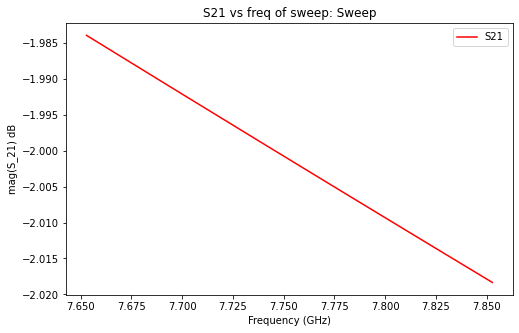

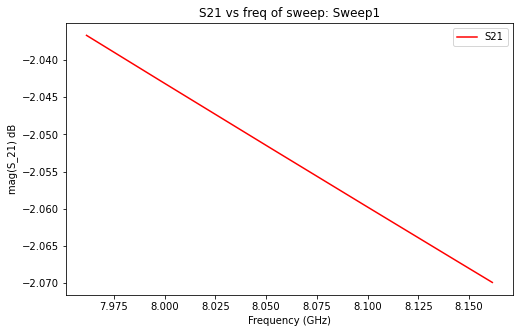

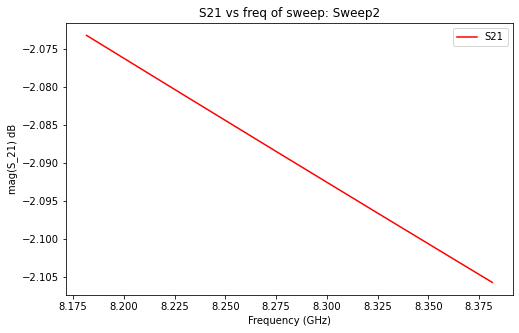

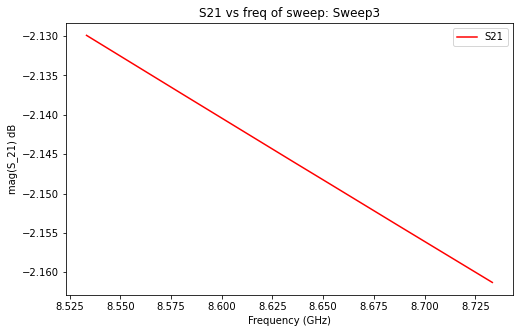

In [58]:
"""
Driven Modal setup for 2D sample:

Now we will modify teh code above to create a new Driven Modal simulation where we replace the 50ohm ports with lumped ports and
setup a DM simulation with frequency sweeps. 
"""

project_name='QTune'
design_name='QTune_DM'
overwrite=True

#use file location path:
#use local path
HFSS_path=cwd

full_path=HFSS_path+"\\Simulation Files\\"+project_name+'.aedt'

chip_path=cwd+'\\QTUNE-QTUNE1.dxf'

HFSS_app=HFSS.HfssApp()
HFSS_desktop=HFSS_app.get_app_desktop()

project=HFSS_desktop.open_project(full_path)

if project==None:
    project=HFSS_desktop.new_project()
    project.save(full_path)
    
project.make_active()
    
if design_name in project.get_design_names():
    if overwrite==True:
        project.delete_design(design_name)
        project.save()
        DM_design=project.new_dm_design(design_name)
    else:
        DM_design=project.get_design(design_name)
        
else:
    DM_design=project.new_dm_design(design_name)
        
DM_design.make_active()
model=HFSS.HfssModeler(DM_design)

#imports lumped element filter design and returns a list of all the imported layer groups
layer_group=model.import_DXF(chip_path, self_stitch=True)[0]

#set chip dimensions
chip_x_dim=DM_design.set_variable("chip_x_dim", "2.3mm")
chip_y_dim=DM_design.set_variable("chip_y_dim", "5.6mm")

#set chip origins
chip_x_origin=DM_design.set_variable("chip_x_origin", "2.2mm")
chip_y_origin=DM_design.set_variable("chip_y_origin", "0.5mm")

#set chip thickness
chip_thickness=DM_design.set_variable("chip_thickness", "460um")

#create a ground plane
ground_plane=model.draw_rect_corner([chip_x_origin,chip_y_origin,0], x_size=chip_x_dim, y_size=chip_y_dim)

#we will artificially introduce some loss into the system
ground_plane.make_finite_conductivity(material='aluminum')

#subtract the layer group objects (extracted using model.get_objects_in_group) and subtracts them from the ground_plane
ground_plane=model.subtract(ground_plane, model.get_objects_in_group(layer_group))

#creates a chip below
chip_thickness=DM_design.set_variable("chip_thickness", "460um")
chip=model.draw_box_corner([chip_x_origin,chip_y_origin,0], size=[chip_x_dim, chip_y_dim, -chip_thickness], material='sapphire')

#draw vacuum around the chip
vac_thickness=DM_design.set_variable("vac_thickness", "1mm")
vacuum=model.draw_box_corner(pos=[chip_x_origin,chip_y_origin,-vac_thickness/2], size=[chip_x_dim, chip_y_dim, vac_thickness], material="vacuum")

#draw mesh boxes for each resonator, first set up some variables
res_loc_x=DM_design.set_variable("res_loc_x", "3.32mm")
res_loc_y=DM_design.set_variable("res_loc_y", "1.5mm")
res_loc_z=DM_design.set_variable("res_loc_z", "100um")

#mesh box dims
res_mesh_box_x_dim=DM_design.set_variable("res_mesh_box_x_dim", "1mm")
res_mesh_box_y_dim=DM_design.set_variable("res_mesh_box_y_dim", "0.9mm")
res_mesh_box_z_dim=DM_design.set_variable("res_mesh_box_z_dim", 2*res_loc_z)

#mesh box offsets
res_y_offset=DM_design.set_variable("res_y_offset", "0.9mm")
res_x_offset=DM_design.set_variable("res_x_offset", "-0.04mm")

mesh_boxes=[]

#make mesh boxes
mesh_boxes.append(model.draw_box_corner(pos=[res_loc_x, res_loc_y, -res_loc_z], size=[res_mesh_box_x_dim, res_mesh_box_y_dim, res_mesh_box_z_dim], nonmodel=True))

mesh_boxes.append(model.draw_box_corner(pos=[res_loc_x+res_x_offset, res_loc_y+res_y_offset, -res_loc_z], size=[-res_mesh_box_x_dim, res_mesh_box_y_dim, res_mesh_box_z_dim], nonmodel=True))

mesh_boxes.append(model.draw_box_corner(pos=[res_loc_x, res_loc_y+2*res_y_offset, -res_loc_z], size=[res_mesh_box_x_dim, res_mesh_box_y_dim, res_mesh_box_z_dim], nonmodel=True))

mesh_boxes.append(model.draw_box_corner(pos=[res_loc_x+res_x_offset, res_loc_y+3*res_y_offset, -res_loc_z], size=[-res_mesh_box_x_dim, res_mesh_box_y_dim, res_mesh_box_z_dim], nonmodel=True))

#set the mesh length for the mesh boxes
model.mesh_length("Res_Mesh", objects=mesh_boxes, max_length='0.5mm')

#now lets do some wirebonds, set up some variables
WB_pos_x=DM_design.set_variable("WB_pos_x", "3.1mm")
WB_pos_y=DM_design.set_variable("WB_pos_y", "1.5mm")
WB_dir_x=DM_design.set_variable("WB_dir_x", "0.4mm")
WB_dir_y=DM_design.set_variable("WB_dir_y", "0.0mm")
WB_trans_y=DM_design.set_variable("WB_trans_y", "0.9mm")
WB_dist=DM_design.set_variable("WB_dia", "0.4mm")
WB_height=DM_design.set_variable("WB_height", "0.1mm")

wirebonds=[]

#make wirebonds
for i in range(0,5):
    wirebonds.append(model.draw_wirebond(pos=[WB_pos_x, WB_pos_y+i*WB_trans_y, 0], ori=[WB_dir_x, WB_dir_y,  0], width=WB_dist, height=WB_height))

#assign perfect E to wirebonds, make sure solve inside is off
model.assign_material(wirebonds, material="perfect conductor", solve_inside=False)

#add 50ohms to the ports, create more variables
port_x_dim=DM_design.set_variable("port_x_dim", "0.15mm")
port_y_dim=DM_design.set_variable("port_y_dim", "0.075mm")
port_1_x_loc=DM_design.set_variable("port_1_x_loc", "3.225mm")
port_1_y_loc=DM_design.set_variable("port_1_y_loc", "0.775mm")
port_2_x_loc=DM_design.set_variable("port_2_x_loc", port_1_x_loc)
port_2_y_loc=DM_design.set_variable("port_2_y_loc", "5.825mm")

#now create a eigenmode setup
port_1=model.draw_rect_corner(pos=[port_1_x_loc, port_1_y_loc, 0], x_size=port_x_dim, y_size=-port_y_dim)

#now we want to make them 50ohm lumped ports instead of impedences
port_1.make_lumped_port(axis='Y', z0="50ohm", name="Port_1")

port_2=model.draw_rect_corner(pos=[port_2_x_loc, port_2_y_loc, 0], x_size=port_x_dim, y_size=port_y_dim)
port_2.make_lumped_port(axis='Y', z0="50ohm", name="Port_2")

#add frequency sweep setup
DM_setup=DM_design.create_dm_setup(freq_ghz=1,
                                    name="QTune_DM",
                                    max_delta_s=0.1,
                                    max_passes=10,
                                    min_passes=1,
                                    min_converged=1, 
                                    pct_refinement=30,
                                    basis_order=-1
                                    )

sweeps=[]
span=.1
#now lets add sweeps based on the eigenmode frequencies
for freqs in eigen_real[0:4]:
    sweeps.append(DM_setup.insert_sweep(start_ghz=freqs-span,
                                stop_ghz=freqs+span,
                                count=20000,
                                step_ghz=None,#<--If you rather use frequency step use this, otherwise use step and set to none (or vis-versa)
                                type="Fast",
                                save_fields=False))

#start analysis of the above DM setup and sweeps
DM_setup.analyze()

#print sweep data in form of rectangular plots:
for sweep in sweeps:
    S21_array=sweep.get_report_arrays(expr="db(S(Port_1,Port_2))")
    #plot the admittance
    freq=S21_array[0]
    mag_S21=S21_array[1]

    plt.figure(figsize=(8,5))
    plt.plot(freq, mag_S21, '-r', label="S21")
    plt.xlabel('Frequency (GHz)')
    plt.ylabel('mag(S_21) dB')
    plt.legend()
    plt.title('S21 vs freq of sweep: %s'%sweep.name)